In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [2]:
from pylibs.histo_funcs import *

In [3]:
import yfinance as yf

asset = "ES=F"
tk = yf.Ticker(asset)
hist = tk.history(period="max", interval="1mo", auto_adjust=False)[
    ["Close"]
]  # [['Open', 'High', 'Low', 'Close', 'Volume']]
hist.columns = [c.lower() for c in hist.columns]
hist["r_12m"] = hist["close"].pct_change(12)

print(f"{hist.shape = }")
print(hist.head().to_string())

hist.shape = (257, 2)
                            close  r_12m
Date                                    
2000-09-01 00:00:00-04:00  1454.0    NaN
2000-11-01 00:00:00-05:00  1321.0    NaN
2000-12-01 00:00:00-05:00  1327.0    NaN
2001-01-01 00:00:00-05:00  1373.5    NaN
2001-02-01 00:00:00-05:00  1242.0    NaN


In [ ]:
tt = pd.read_csv("input/titanic.csv")
print(f"{tt.shape}")
print(tt.head().to_string())

(891, 15)
   survived  pclass     sex   age  sibsp  parch     fare embarked  class    who  adult_male deck  embark_town alive  alone
0         0       3    male  22.0      1      0   7.2500        S  Third    man        True  NaN  Southampton    no  False
1         1       1  female  38.0      1      0  71.2833        C  First  woman       False    C    Cherbourg   yes  False
2         1       3  female  26.0      0      0   7.9250        S  Third  woman       False  NaN  Southampton   yes   True
3         1       1  female  35.0      1      0  53.1000        S  First  woman       False    C  Southampton   yes  False
4         0       3    male  35.0      0      0   8.0500        S  Third    man        True  NaN  Southampton    no   True


### 5 numbers / box plot

In [5]:
dat = hist["r_12m"].dropna()
fivnum = calc_7_numbers(dat)
fivnum

[np.float64(-0.44322220341851415),
 -0.25436611381110075,
 0.025267470976553685,
 0.11741214057507987,
 0.21168986083498997,
 np.float64(0.4575388620874492),
 np.float64(0.4575388620874492)]

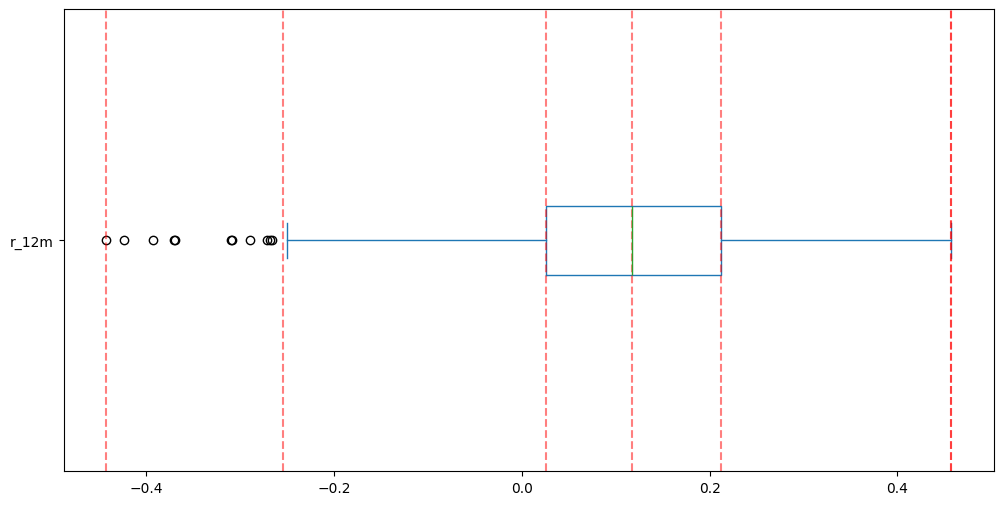

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
dat.plot(kind='box', vert=False, ax=ax)
for n in fivnum:
    ax.axvline(n, color='red', linestyle='--', alpha=0.5)

### histgram with fixed width bars

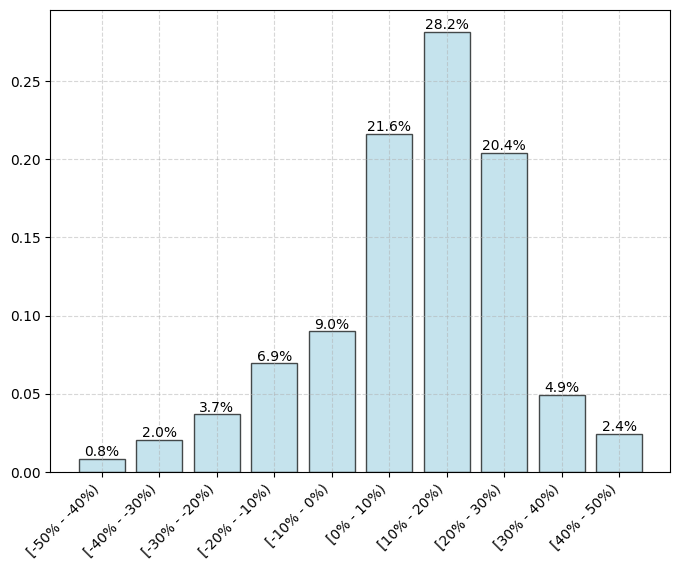

In [18]:
df = hist
col = "r_12m"
ff = lambda x: ~x[col].isna()
edges = np.linspace(-0.5, 0.5, 11)

df[f"{col}_binned"] = None
df.loc[ff, f"{col}_binned"] = pd.cut(df.loc[ff, col], bins=edges, right=False)
freqs = calc_freq_signal(df.loc[ff], col=f"{col}_binned")
fig, ax = plot_pct_interval_histogram(
    x_ticks=np.arange(freqs.shape[0], dtype=int),
    x_labels=bin_cat_to_pct_labels(freqs.index),
    y=freqs[f"{col}_binned_freq"],
)
plt.close()
fig

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
col = "r_12m"
ff = lambda x: ~x[col].isna()

# even width
pct_histogram_from_pct_edges(
    df = hist,
    ff = ff,
    col = col,
    edges = np.histogram_bin_edges(hist.loc[ff,col], bins=10),
    ax = axs[0][0]
)

# even width 2
pct_histogram_from_pct_edges(
    df = hist,
    ff= ff,
    col = col,
    edges = np.linspace(-0.5, 0.5, 11),
    ax = axs[0][1]
)

# by proportion
pct_histogram_from_pct_edges(
    df = hist,
    ff= ff,
    col = col,
    edges = hist.loc[ff,col].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).to_list(),
    ax = axs[1][0]
)

# defined
pct_histogram_from_pct_edges(
    df = hist,
    ff= ff,
    col = col,
    edges = [-np.inf, -0.0, 0.05, 0.15, np.inf],
    ax = axs[1][1]
)

plt.tight_layout()
plt.close("all")

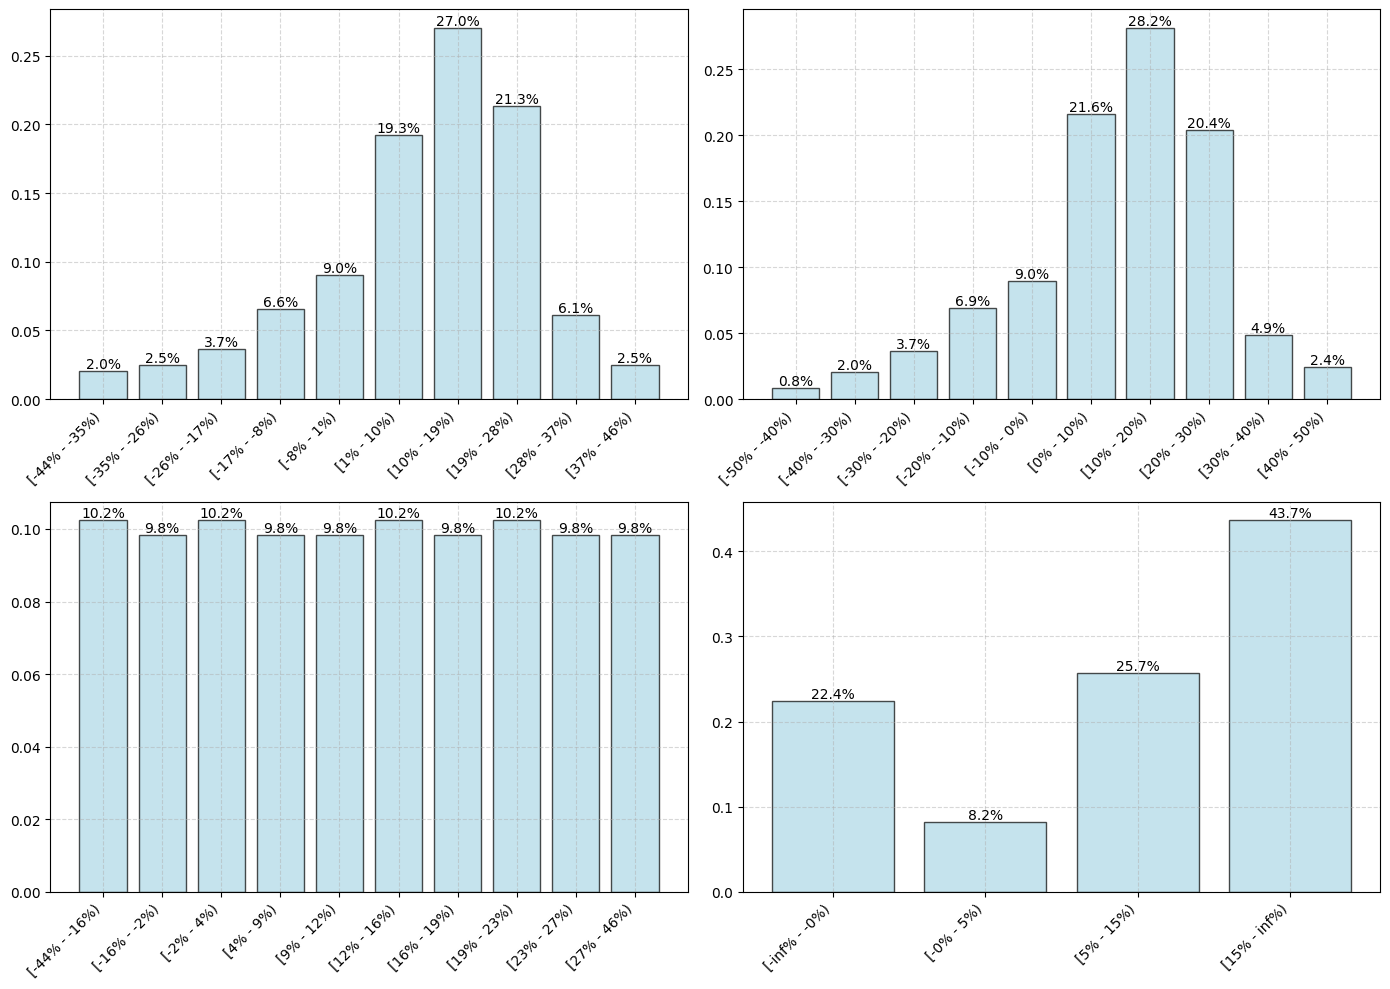

In [8]:
fig